In [46]:
import pandas as pd
from pathlib import Path

# from helpers_mfq import mfq_part1, mfq_part2

In [47]:
model = "gpt-4"

MFQ INFO

In [48]:
# questions1 = [q for q in mfq_part1.split("\n\n")[2].split("\n") if q]
# questions2 = [q for q in mfq_part2.split("\n\n")[2].split("\n") if q]

questions1_item_key = [
    ("emotionally", "care"),
    ("treated", "fairness"),
    ("lovecountry", "loyalty"),
    ("respect", "authority"),
    ("decency", "sanctity"),
    ("math", None),
    ("weak", "care"),
    ("unfairly", "fairness"),
    ("betray", "loyalty"),
    ("traditions", "authority"),
    ("disgusting", "sanctity"),
    ("cruel", "care"),
    ("rights", "fairness"),
    ("loyalty", "loyalty"),
    ("chaos", "authority"),
    ("god", "sanctity"),
]

questions2_item_key = [
    ("compassion", "care"),
    ("fairly", "fairness"),
    ("history", "loyalty"),
    ("kidrespect", "authority"),
    ("harmlessdg", "sanctity"),
    ("good", None),
    ("animal", "care"),
    ("justice", "fairness"),
    ("family", "loyalty"),
    ("sexroles", "authority"),
    ("unnatural", "sanctity"),
    ("kill", "care"),
    ("rich", "fairness"),
    ("team", "loyalty"),
    ("soldier", "authority"),
    ("chastity", "sanctity"),
]

Analysing data


In [49]:
from pathlib import Path
df_chat = pd.concat(
    map(pd.read_csv, Path("data/mfq").glob(f"*{model}*.csv")),
)

In [50]:
df_chat.groupby("condition")["math"].value_counts()

condition  math
after      0       128
before     0       128
Name: math, dtype: int64

In [51]:
df_chat.groupby("condition")["good"].value_counts()

condition  good
after      0        78
           5        48
           3         2
before     5       128
Name: good, dtype: int64

Filtering rows based on control questions - only one case was filtered out

In [52]:
df_chat.query("math < 3 and good > 2", inplace=True)

# drop cols
df_chat.drop(columns=["math", "good"], inplace=True)

In [53]:
df_chat.groupby("condition", as_index=False).nunique().apply(pd.Series.value_counts, axis=1)

,1,2,3,4,5,6,after,50,before,128
0,8.0,25.0,26.0,23.0,11.0,5.0,1.0,1.0,NaN,NaN
1,15.0,26.0,28.0,22.0,7.0,NaN,NaN,NaN,1.0,1.0


# Compare before and after distributions

In [54]:
import numpy as np
def cohen_d(x,y):
        from math import sqrt
        std_factor = sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
        if std_factor == 0:
            return np.nan
        return (np.mean(x) - np.mean(y))


def compare_subsets_distributions(df_before, df_randomized):
    import scipy.stats
    from scipy.stats import mannwhitneyu
    from statsmodels.stats.multitest import multipletests
    test_results = list()

    for code in df_before.columns:
        ordered_answers = df_before[code]

        randomized_answer = df_randomized[code]
        if df_randomized[str(code)].nunique() < 3 or df_before[str(code)].nunique() < 3:
            print(
                f"Code: {code} had {df_before[str(code)].nunique()} different answers when generated in before"
            )
            print(
                f"Code: {code} had {df_randomized[str(code)].nunique()} different answers when generated in after"
            )

        test_results.append(
            (
                code,
                np.median(ordered_answers),
                scipy.stats.median_abs_deviation(ordered_answers),
                np.median(randomized_answer),
                scipy.stats.median_abs_deviation(randomized_answer),
                cohen_d(ordered_answers, randomized_answer),
                *mannwhitneyu(ordered_answers, randomized_answer),
            )
        )

    df_tests = pd.DataFrame(
        test_results,
        columns=["mfv_code", "mediana_ordered", "MAD_ordered", "mediana_randomized", "MAD_randomized", "cohen_d", "u", "p-value"],
    )
    df_tests["rejected"], df_tests["adjusted_p-value"], _, _ = multipletests(
        df_tests["p-value"],
        alpha=0.05,
        method="bonferroni"
    )
    # round adjusted p-value to 3 decimals
    df_tests["adjusted_p-value"] = df_tests["adjusted_p-value"].apply(lambda x: round(x, 4))

    df_tests["median_dif"] = df_tests["mediana_ordered"] - df_tests["mediana_randomized"]
    return df_tests

In [55]:
before_after_comparison = compare_subsets_distributions(
    df_chat.query("condition == 'before'").drop(columns=["id", "condition"]),
    df_chat.query("condition == 'after'").drop(columns=["id", "condition"]),
)

Code: emotionally had 1 different answers when generated in before
Code: emotionally had 2 different answers when generated in after
Code: treated had 1 different answers when generated in before
Code: treated had 2 different answers when generated in after
Code: weak had 1 different answers when generated in before
Code: weak had 2 different answers when generated in after
Code: unfairly had 1 different answers when generated in before
Code: unfairly had 2 different answers when generated in after
Code: cruel had 1 different answers when generated in before
Code: cruel had 2 different answers when generated in after
Code: rights had 1 different answers when generated in before
Code: rights had 2 different answers when generated in after
Code: compassion had 2 different answers when generated in before
Code: compassion had 4 different answers when generated in after
Code: fairly had 2 different answers when generated in before
Code: fairly had 3 different answers when generated in afte

In [56]:
before_after_comparison["rejected"].value_counts()

True     50
False    48
Name: rejected, dtype: int64

In [57]:
before_after_comparison.query("rejected == True")

,mfv_code,mediana_ordered,MAD_ordered,mediana_randomized,MAD_randomized,cohen_d,u,p-value,rejected,adjusted_p-value,median_dif
0,emotionally,5.0,0.0,5.0,0.0,0.500000,3520.0,3.024660e-04,True,0.0296,0.0
1,treated,5.0,0.0,5.0,0.0,0.500000,3520.0,3.024660e-04,True,0.0296,0.0
2,lovecountry,3.0,1.0,0.0,0.0,2.054688,5814.0,8.482938e-19,True,0.0000,3.0
3,respect,4.0,0.0,0.0,0.0,2.480000,5760.0,1.430792e-18,True,0.0000,4.0
4,decency,4.0,0.0,0.0,0.0,2.888750,6083.5,5.240826e-27,True,0.0000,4.0
5,weak,5.0,0.0,5.0,0.0,0.500000,3520.0,3.024660e-04,True,0.0296,0.0
6,unfairly,5.0,0.0,5.0,0.0,0.500000,3520.0,3.024660e-04,True,0.0296,0.0
7,betray,4.0,0.0,0.0,0.0,2.432500,5425.5,3.208942e-17,True,0.0000,4.0
8,traditions,3.0,0.0,0.0,0.0,1.694688,5486.5,2.092211e-15,True,0.0000,3.0
9,disgusting,4.0,0.0,0.0,0.0,2.731562,6054.5,1.023473e-25,True,0.0000,4.0


In [58]:
before_after_comparison.query("rejected == True")["median_dif"].describe()

count    50.000000
mean      1.310000
std       1.428179
min      -1.000000
25%       0.000000
50%       1.000000
75%       2.375000
max       4.000000
Name: median_dif, dtype: float64

In [59]:
# make a dictionary with the second value of elements in questions1_item_key as keys and the first value as values. Repeated keys should generate a list of values
questions_dict = {}
for i in questions1_item_key + questions2_item_key:
    if i[1] is None:
        continue
    if i[1] in questions_dict:
        questions_dict[i[1]].append(i[0])
    else:
        questions_dict[i[1]] = [i[0]]



# Generating alphas

In [60]:
alphas = list()

## Cronbach for MFQ foundations

Create dataframe for comparative analysis

In [61]:
df = pd.DataFrame()

df["id"] = df_chat["id"]
df["condition"] = df_chat["condition"]

In [62]:
from pingouin import cronbach_alpha

Intervals represent 95% CI

In [63]:
df_chat.columns

Index(['id', 'condition', 'emotionally', 'treated', 'lovecountry', 'respect',
       'decency', 'weak', 'unfairly', 'betray', 'traditions', 'disgusting',
       'cruel', 'rights', 'loyalty', 'chaos', 'god', 'compassion', 'fairly',
       'history', 'kidrespect', 'harmlessdg', 'animal', 'justice', 'family',
       'sexroles', 'unnatural', 'kill', 'rich', 'team', 'soldier', 'chastity',
       '102', '103', '104', '105', '108', '109', '110', '111', '112', '113',
       '114', '201', '202', '203', '204', '205', '206', '207', '208', '303',
       '402', '403', '404', '405', '406', '408', '409', '410', '411', '501',
       '502', '503', '504', '507', '509', '510', '601', '602', '603', '604',
       '605', '608', '610', '611', '612', '614', '701', '702', '703', '704',
       '705', '706', '707', '709', '710', '711', '712', '713', '714', '715',
       '716', '801', '802', '803', '804', '805', '808', '810'],
      dtype='object')

In [64]:
df_chat.query("condition == 'before'").nunique().head(16)

id             128
condition        1
emotionally      1
treated          1
lovecountry      5
respect          4
decency          4
weak             1
unfairly         1
betray           3
traditions       4
disgusting       4
cruel            1
rights           1
loyalty          3
chaos            3
dtype: int64

In [88]:
cronbach_alpha(df_chat.query("condition == 'after'")[questions[3:]])

(0.9686942675159235, array([0.95 , 0.981]))

In [91]:
cronbach_alpha(df_chat.query("condition == 'after'")[questions[:3]])

(0.9309663513351694, array([0.89 , 0.959]))

In [89]:
for foundation, questions in questions_dict.items():
    df[f"MFQ_{foundation.lower()}"] = df_chat[questions].mean(axis=1)
    print(f"Cronbach for {foundation.upper()}:")
    print(cronbach_alpha(df_chat[questions]))
    alphas.append(
        ["MFQ", foundation.title(), "overall", cronbach_alpha(df_chat[questions])[0]]
    )
    alphas.append(
        ["MFQ - part 1", foundation.title(), "overall", cronbach_alpha(df_chat[questions[:3]])[0]]
    )
    alphas.append(
        ["MFQ - part 2", foundation.title(), "overall", cronbach_alpha(df_chat[questions[3:]])[0]]
    )
    # cronbach para before
    print(
        "Before condition:",
        cronbach_alpha(df_chat.query("condition == 'before'")[questions])
    )
    alphas.append(
        ["MFQ", foundation.title(), "before", cronbach_alpha(df_chat.query("condition == 'before'")[questions])[0]]
    )
    alphas.append(
        ["MFQ - part 1", foundation.title(), "before", cronbach_alpha(df_chat.query("condition == 'before'")[questions[:3]])[0]]
    )
    alphas.append(
        ["MFQ - part 2", foundation.title(), "before", cronbach_alpha(df_chat.query("condition == 'before'")[questions[3:]])[0]]
    )
    # after
    print(
        "After condition:",
        cronbach_alpha(df_chat.query("condition == 'after'")[questions])
    )
    alphas.append(
        ["MFQ", foundation.title(), "after", cronbach_alpha(df_chat.query("condition == 'after'")[questions])[0]]
    )
    alphas.append(
        ["MFQ - part 1", foundation.title(), "after", cronbach_alpha(df_chat.query("condition == 'after'")[questions[:3]])[0]]
    )
    alphas.append(
        ["MFQ - part 2", foundation.title(), "after", cronbach_alpha(df_chat.query("condition == 'after'")[questions[3:]])[0]]
    )

Cronbach for CARE:
(0.9072504137241729, array([0.884, 0.927]))
Before condition: (0.05211917750734387, array([-0.227,  0.286]))
After condition: (0.9411225083986561, array([0.912, 0.963]))
HERE
Cronbach for FAIRNESS:
(0.8983128850182127, array([0.873, 0.92 ]))
Before condition: (0.25920700559474585, array([0.041, 0.442]))
After condition: (0.9112872796942357, array([0.867, 0.945]))
HERE
Cronbach for LOYALTY:
(0.9480847377539768, array([0.935, 0.959]))
Before condition: (0.6231549974195768, array([0.512, 0.716]))
After condition: (0.9392557022809124, array([0.909, 0.962]))
HERE
Cronbach for AUTHORITY:
(0.9400838828288862, array([0.925, 0.953]))
Before condition: (0.6985118017581504, array([0.61 , 0.773]))
After condition: (0.9082791498102132, array([0.862, 0.943]))
HERE
Cronbach for SANCTITY:
(0.9449379267624698, array([0.931, 0.957]))
Before condition: (0.6986767485822306, array([0.61 , 0.773]))
After condition: (0.9409565974742343, array([0.911, 0.963]))
HERE


/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/pingouin/reliability.py:144: RuntimeWarning: invalid value encountered in scalar divide
  cronbach = (k / (k - 1)) * (1 - np.trace(C) / C.sum().sum())
/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/pingouin/reliability.py:144: RuntimeWarning: invalid value encountered in scalar divide
  cronbach = (k / (k - 1)) * (1 - np.trace(C) / C.sum().sum())


Generate histogram for each foundation

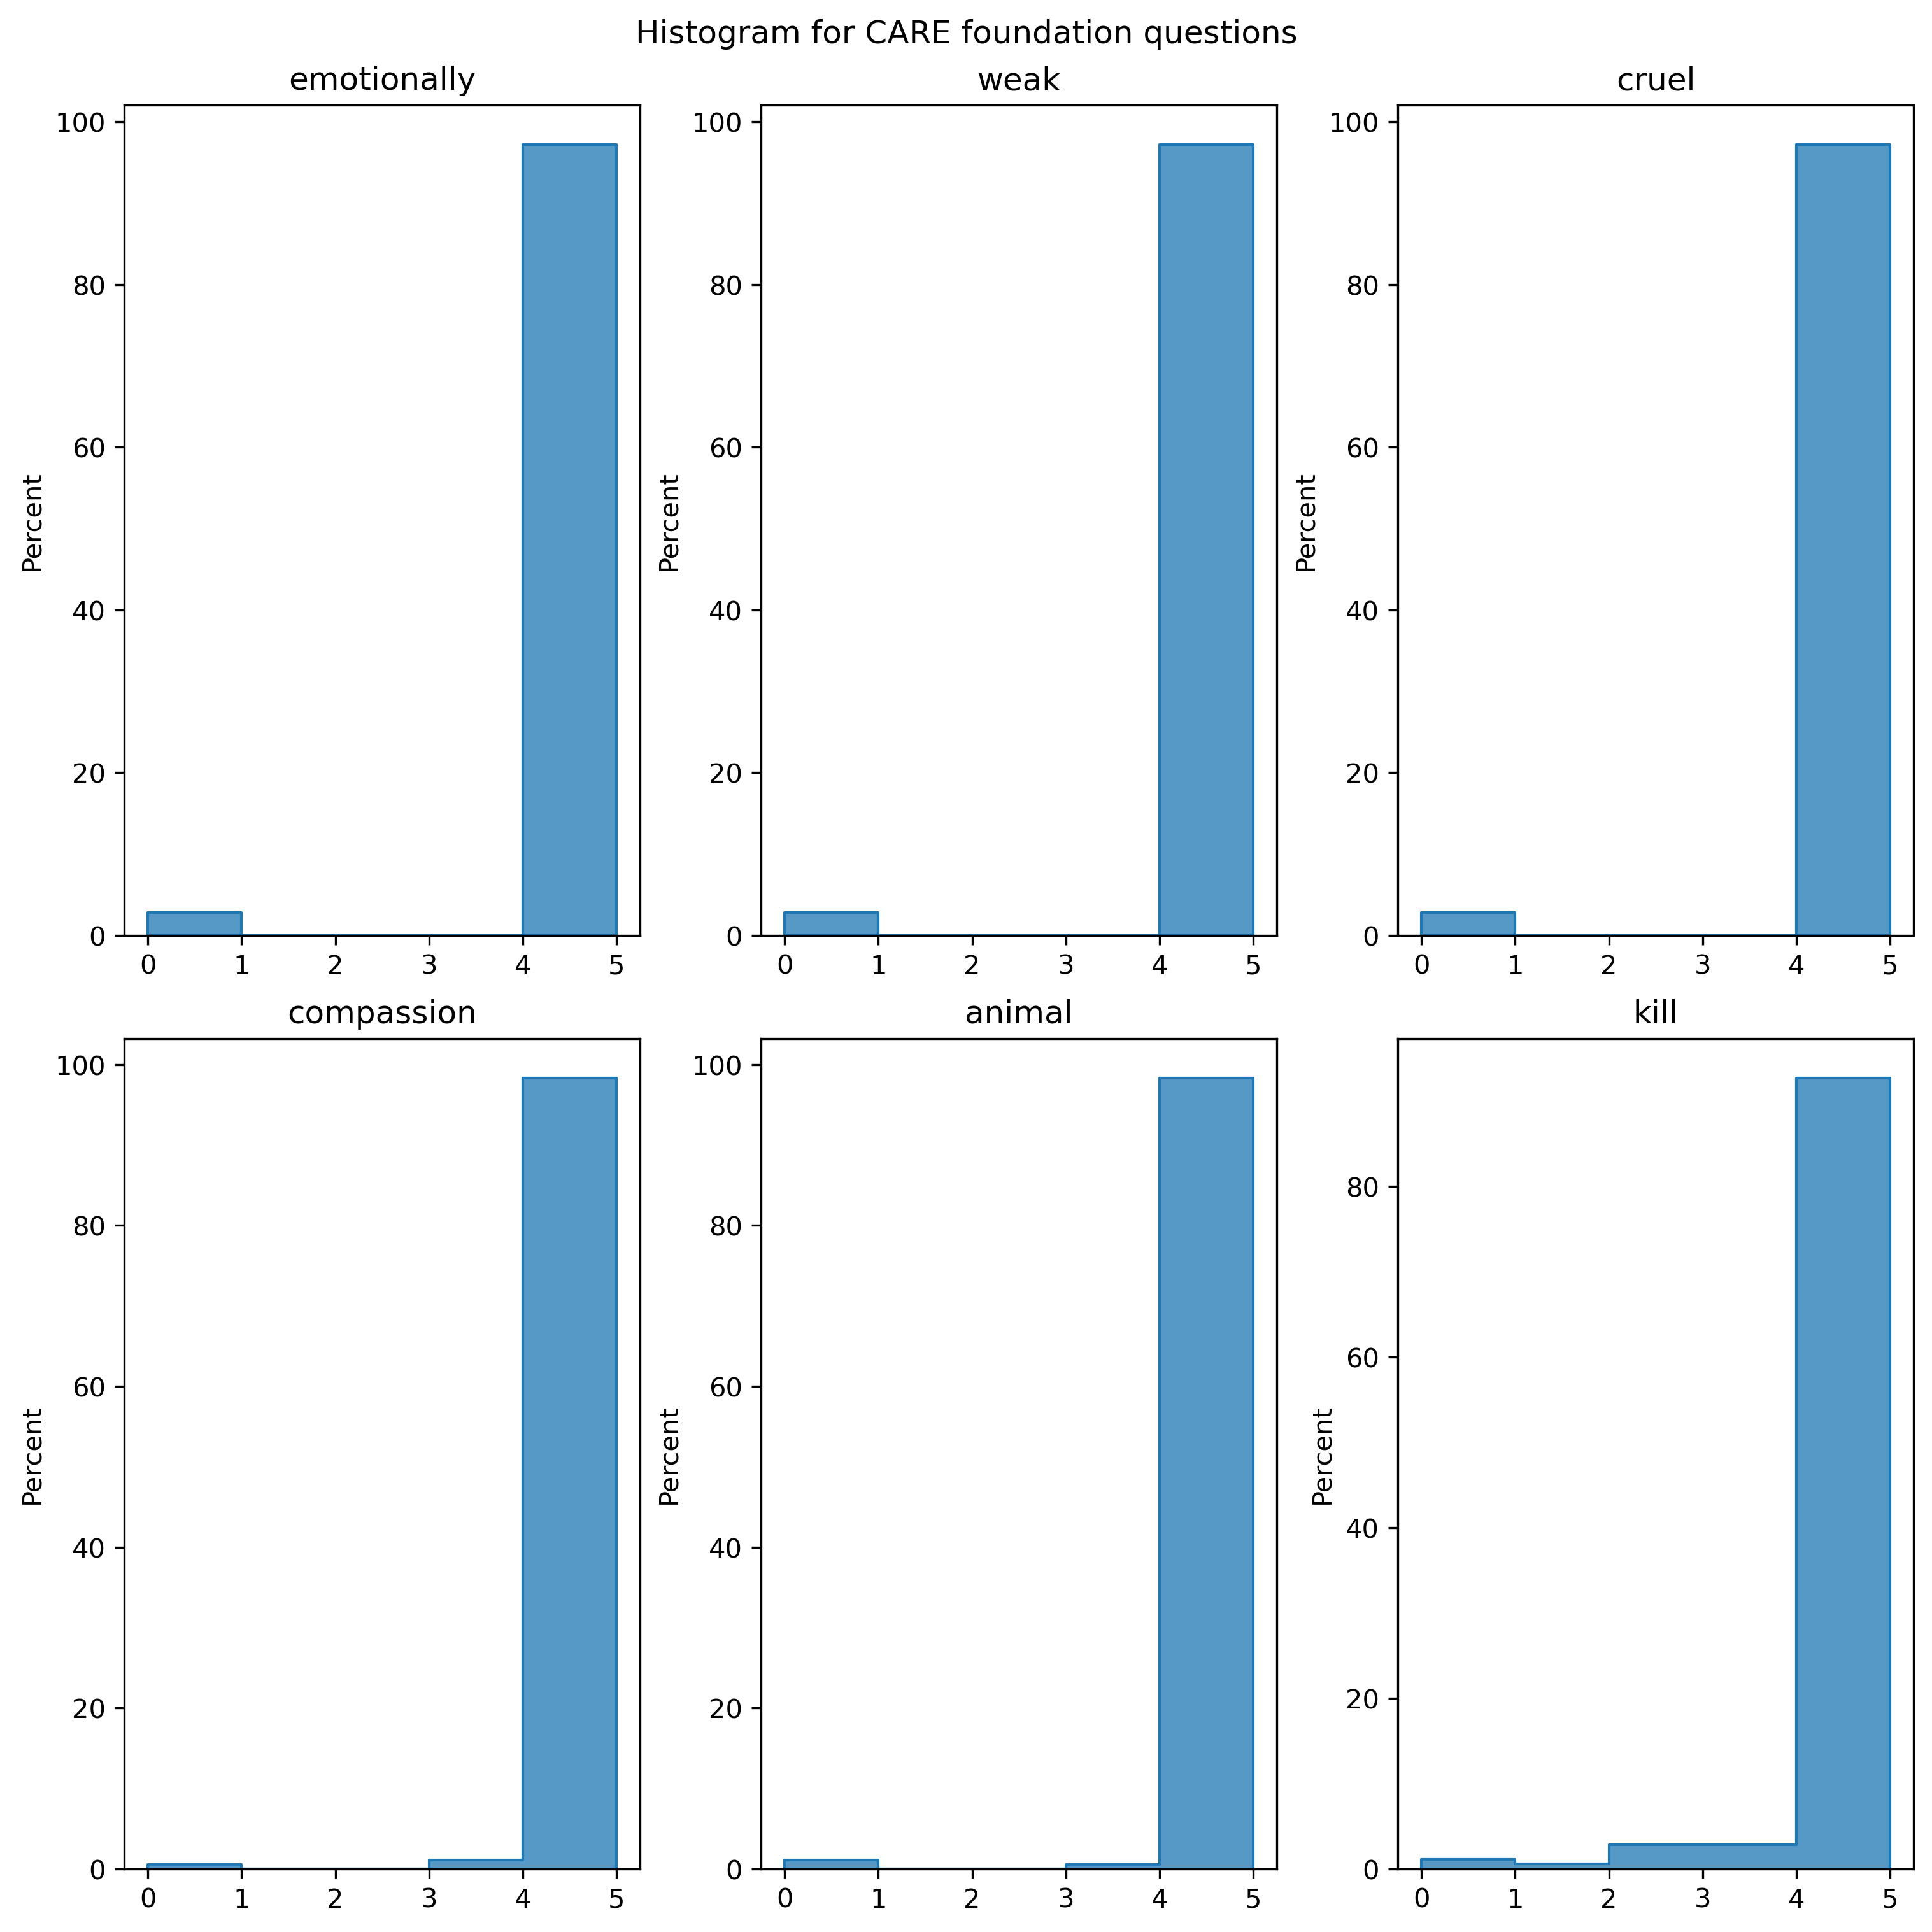

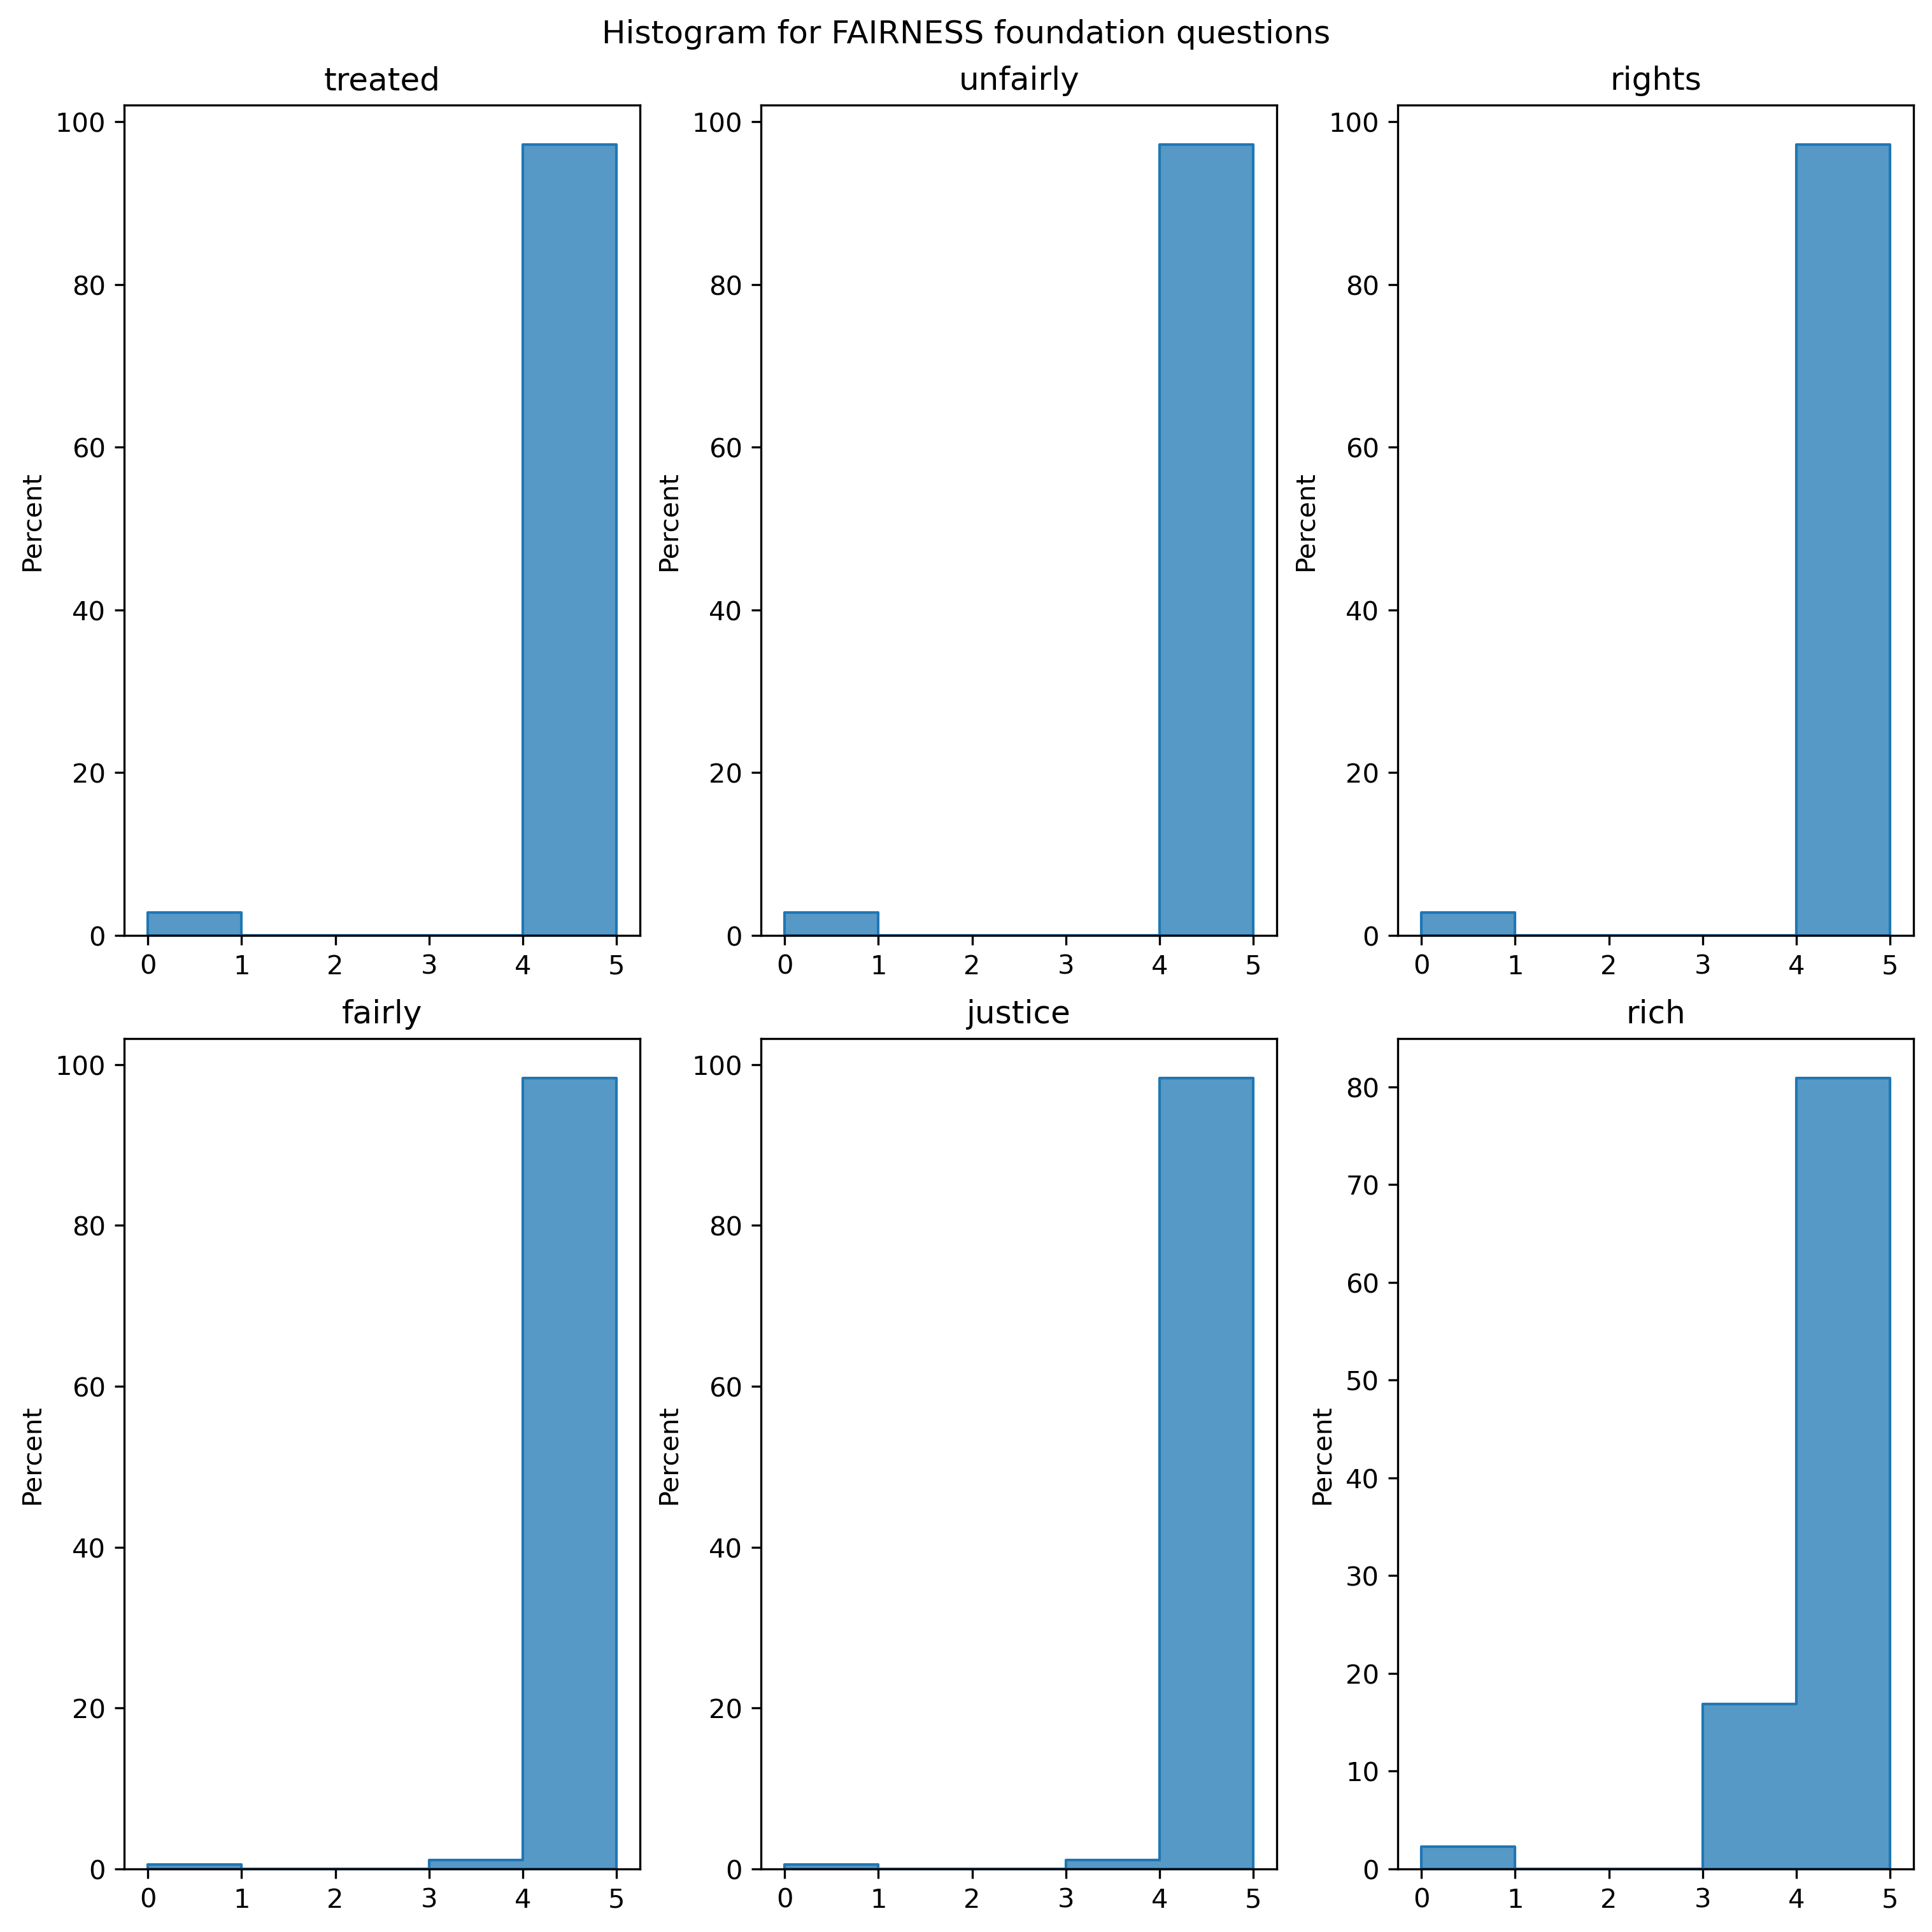

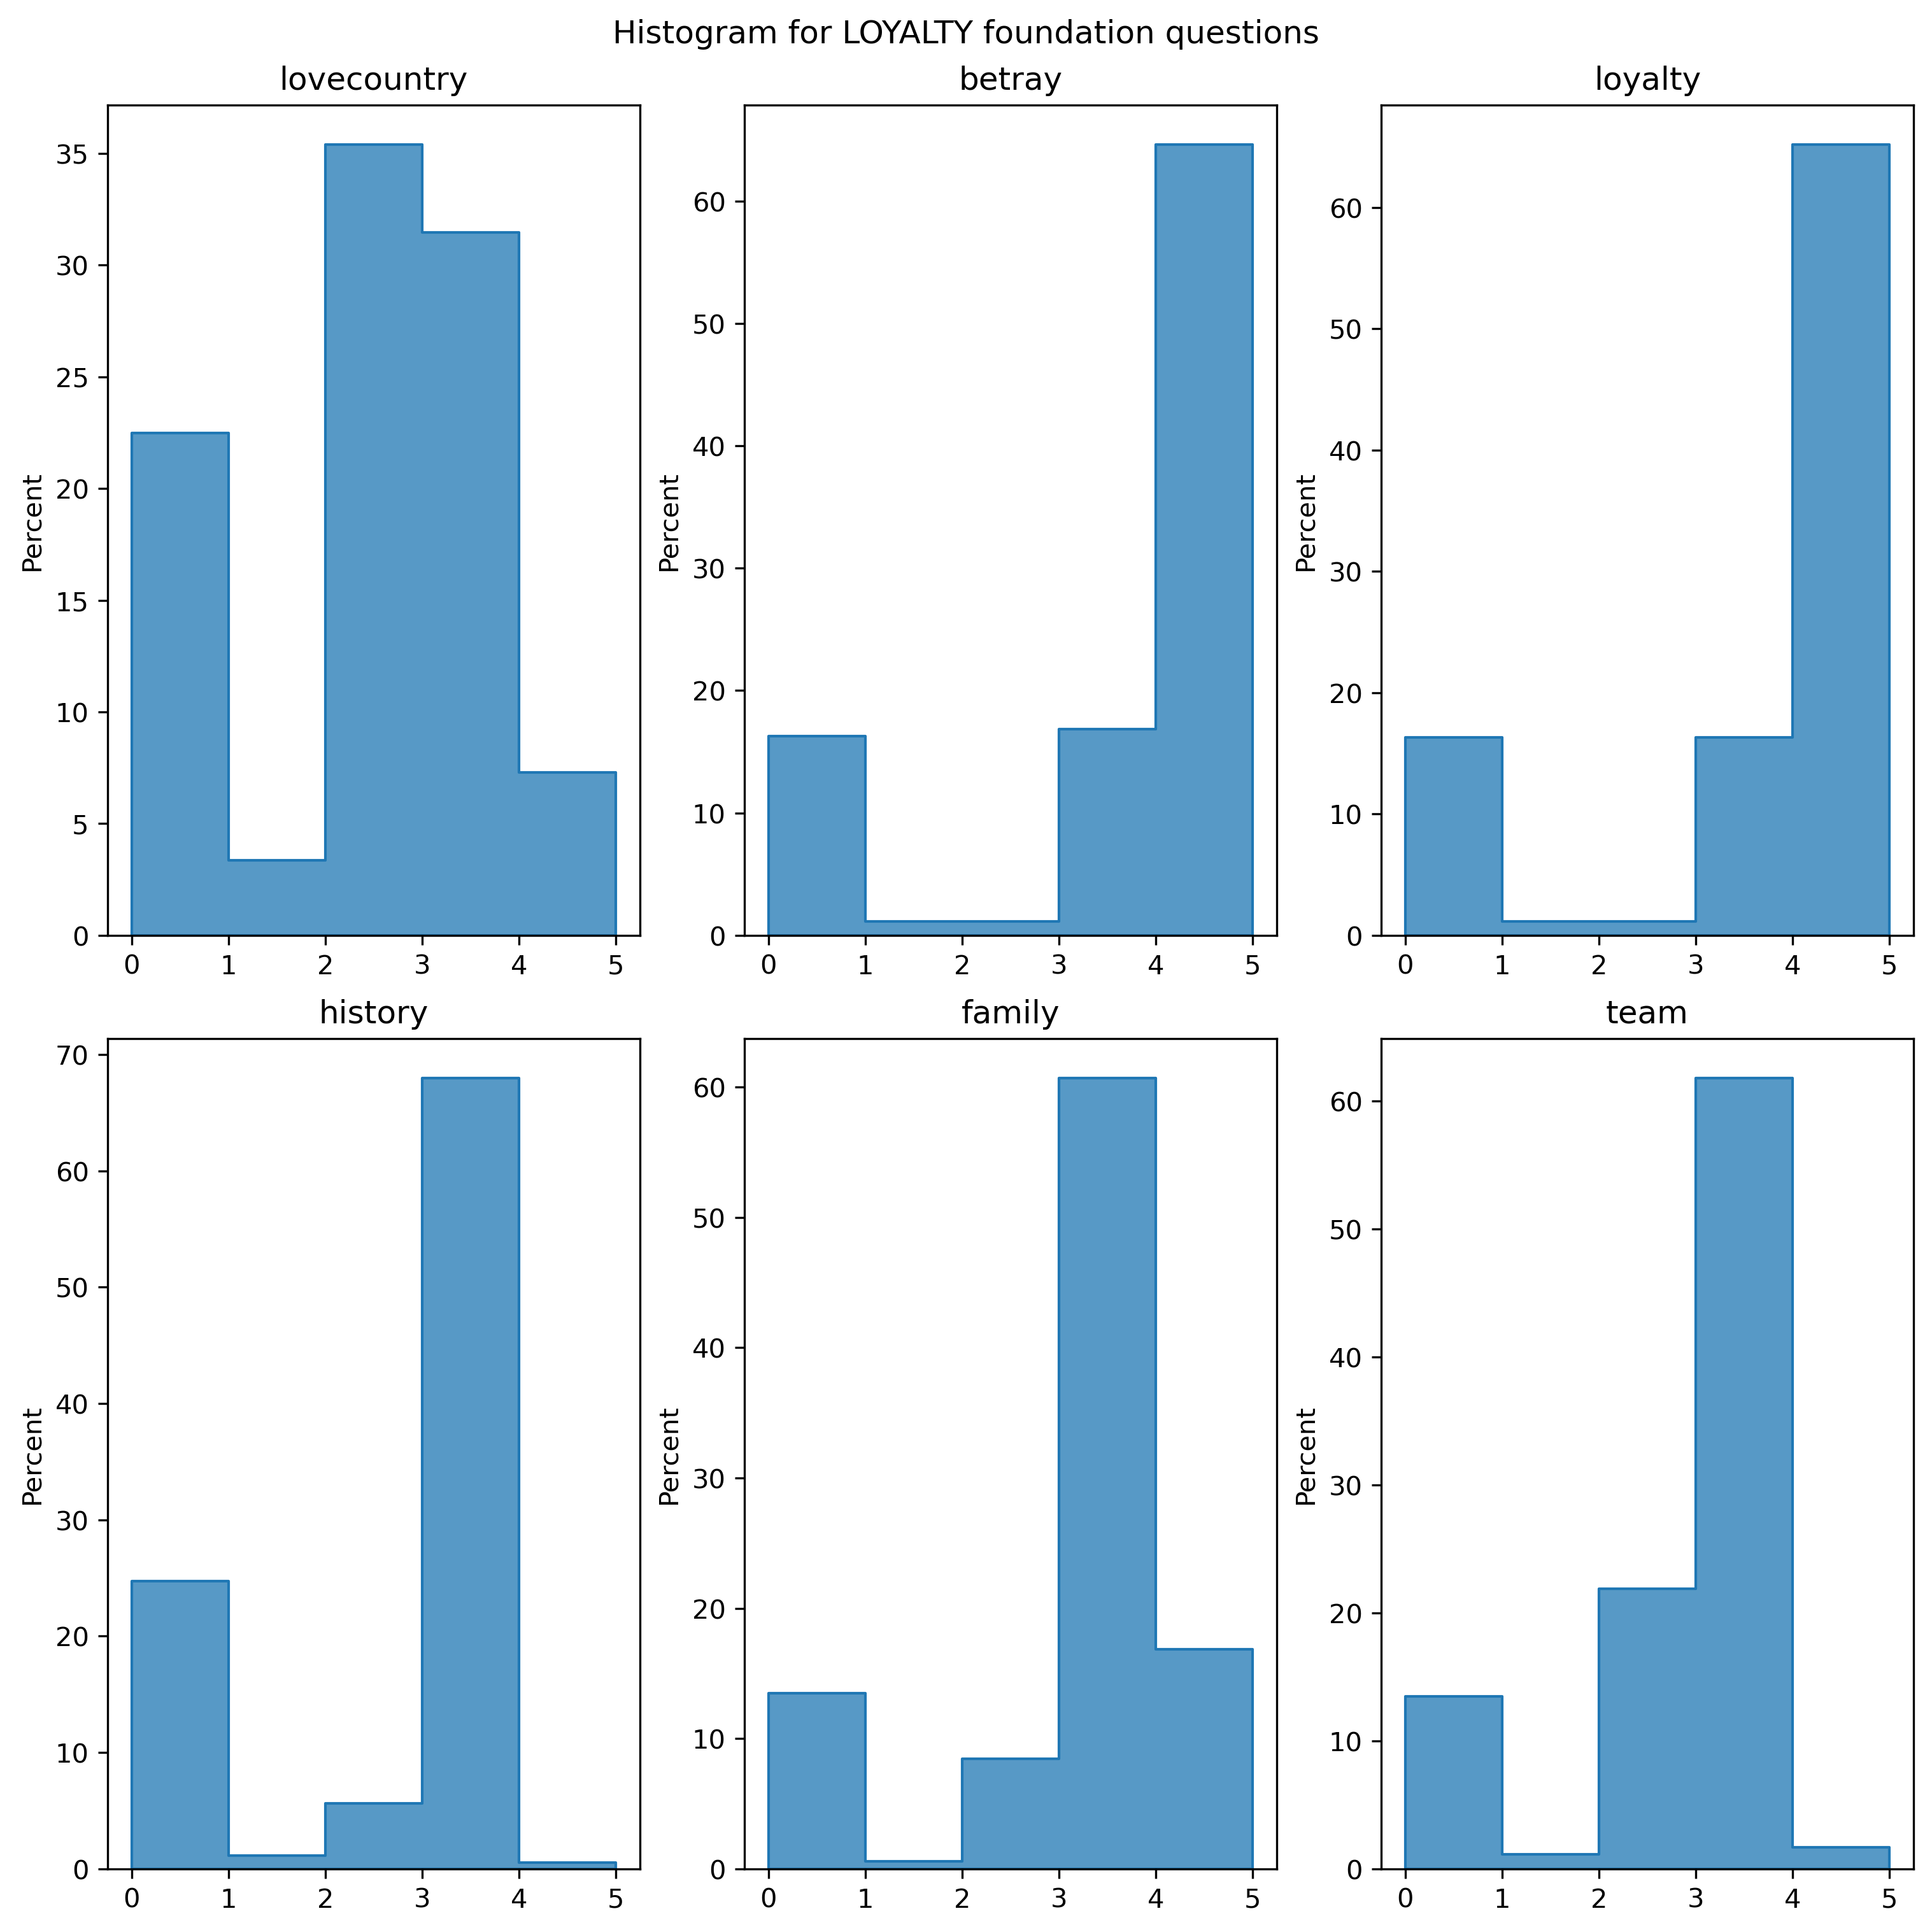

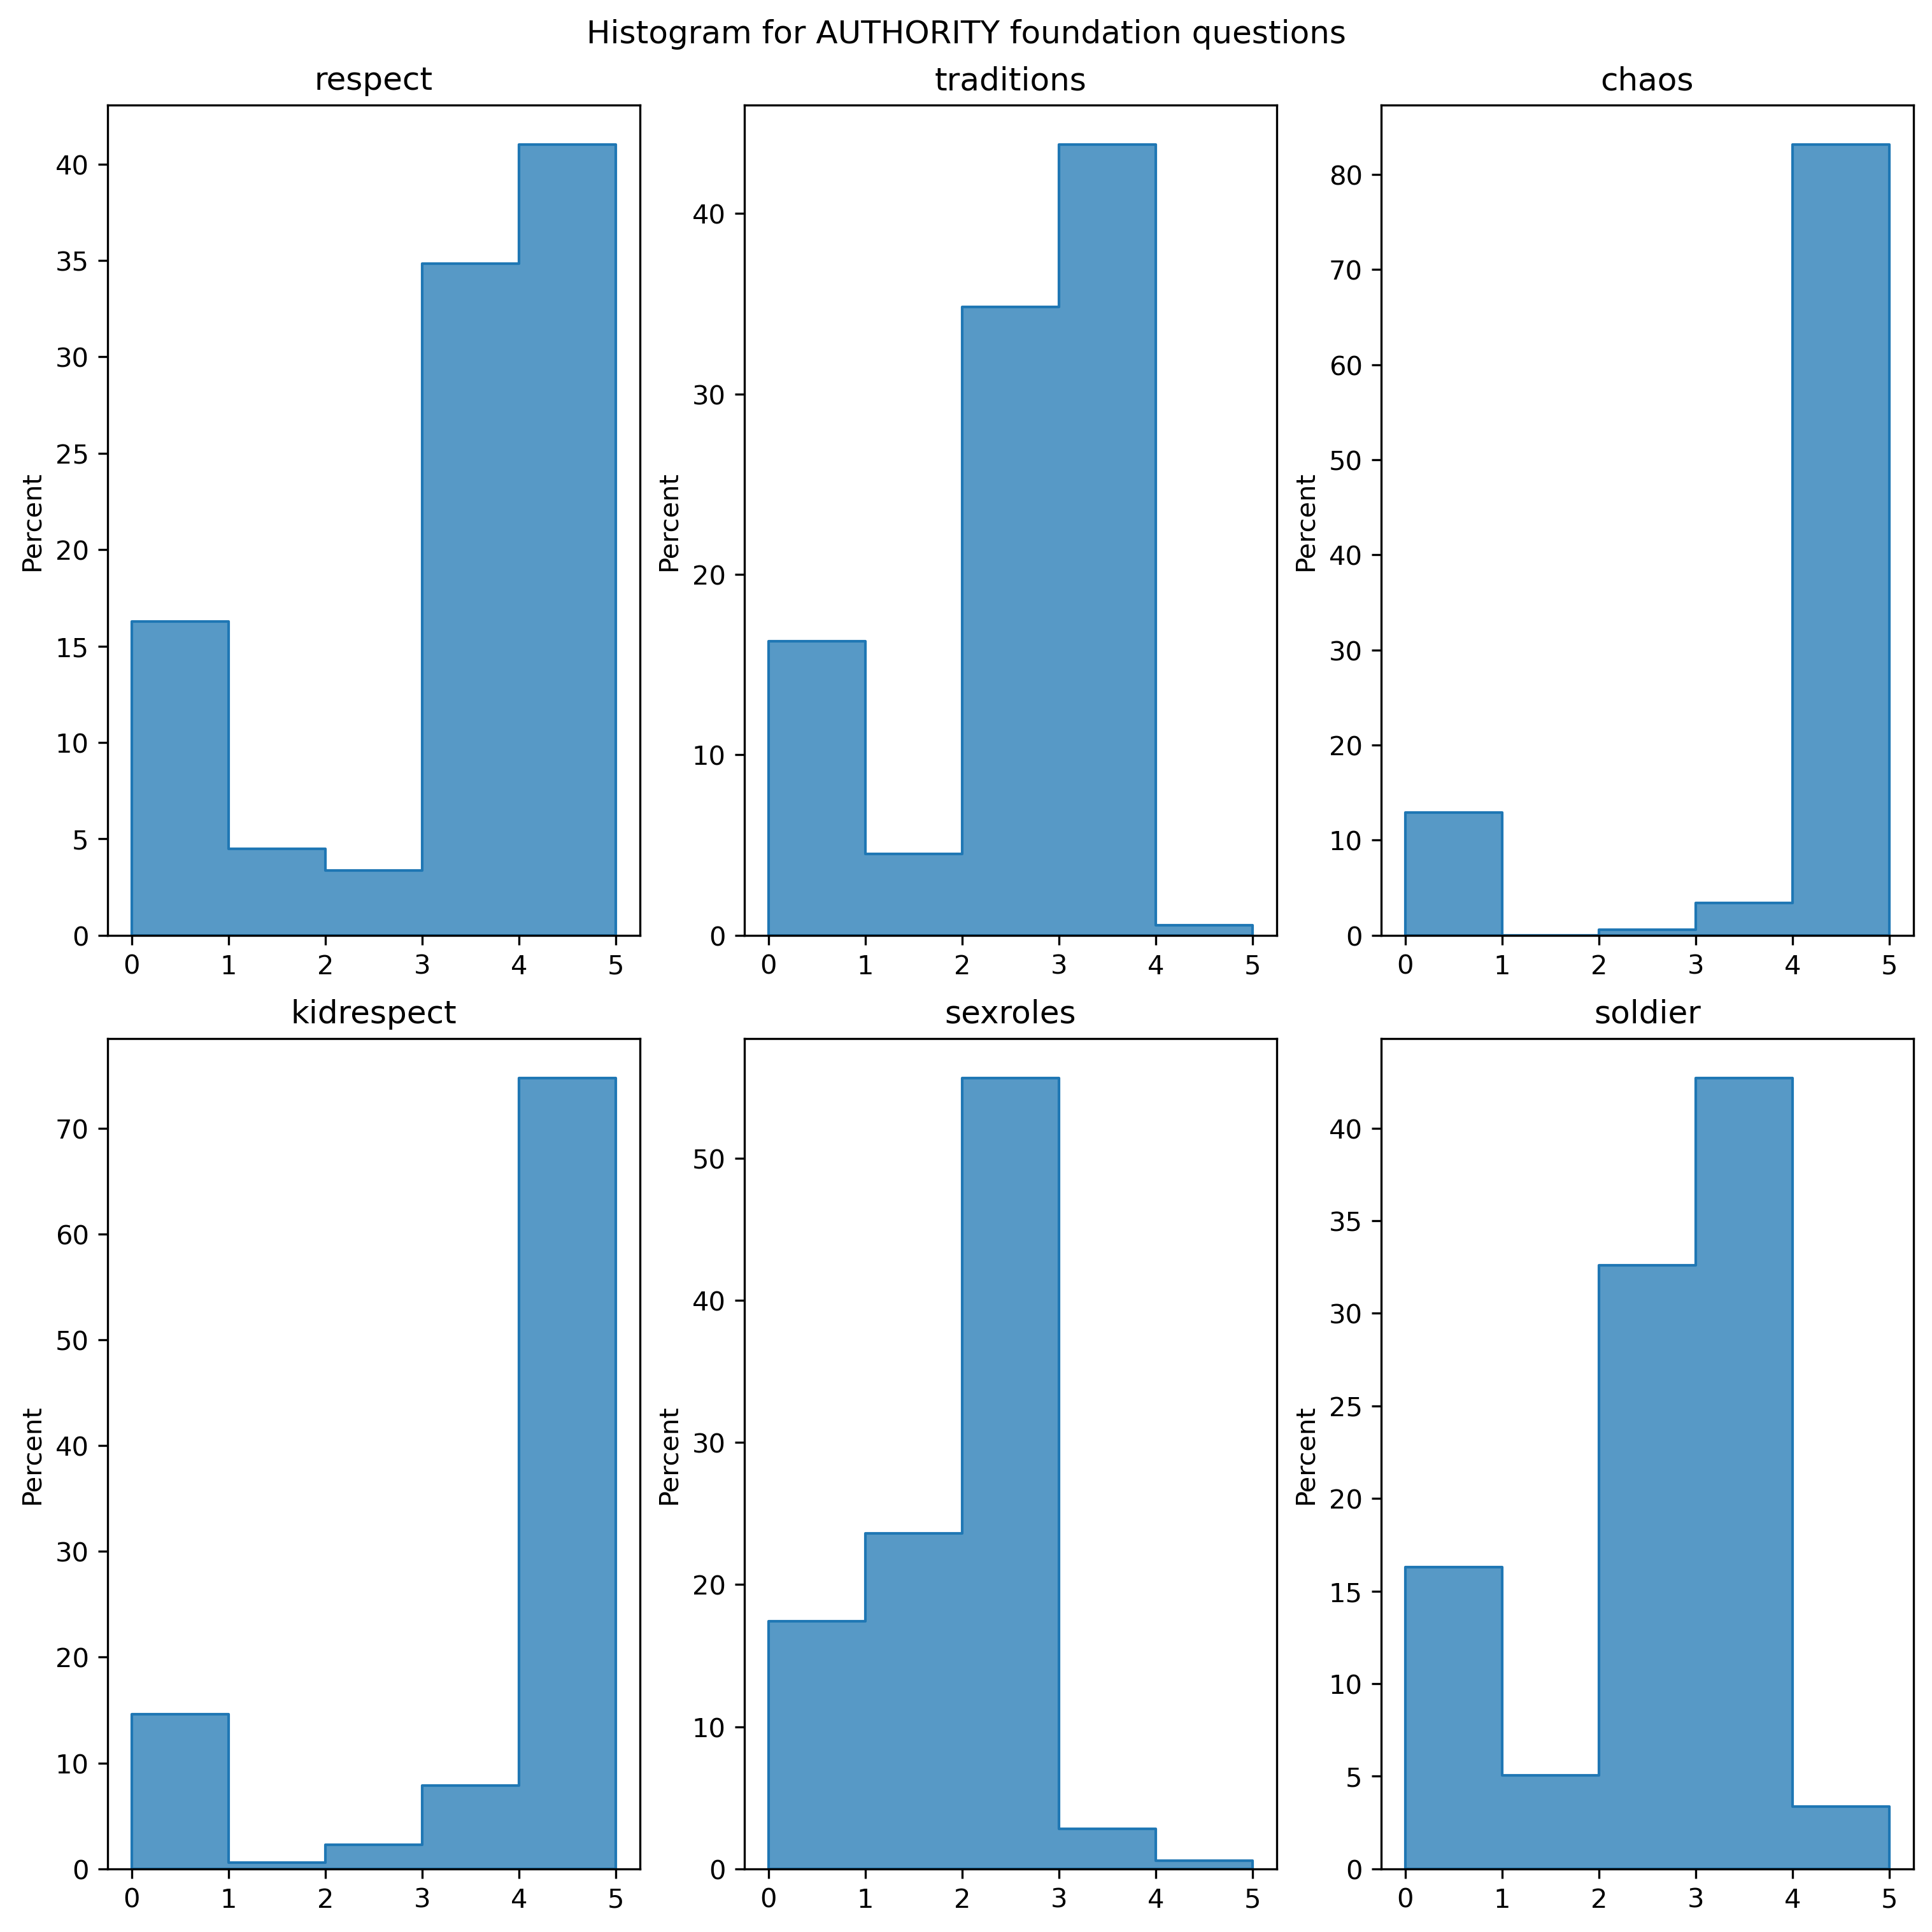

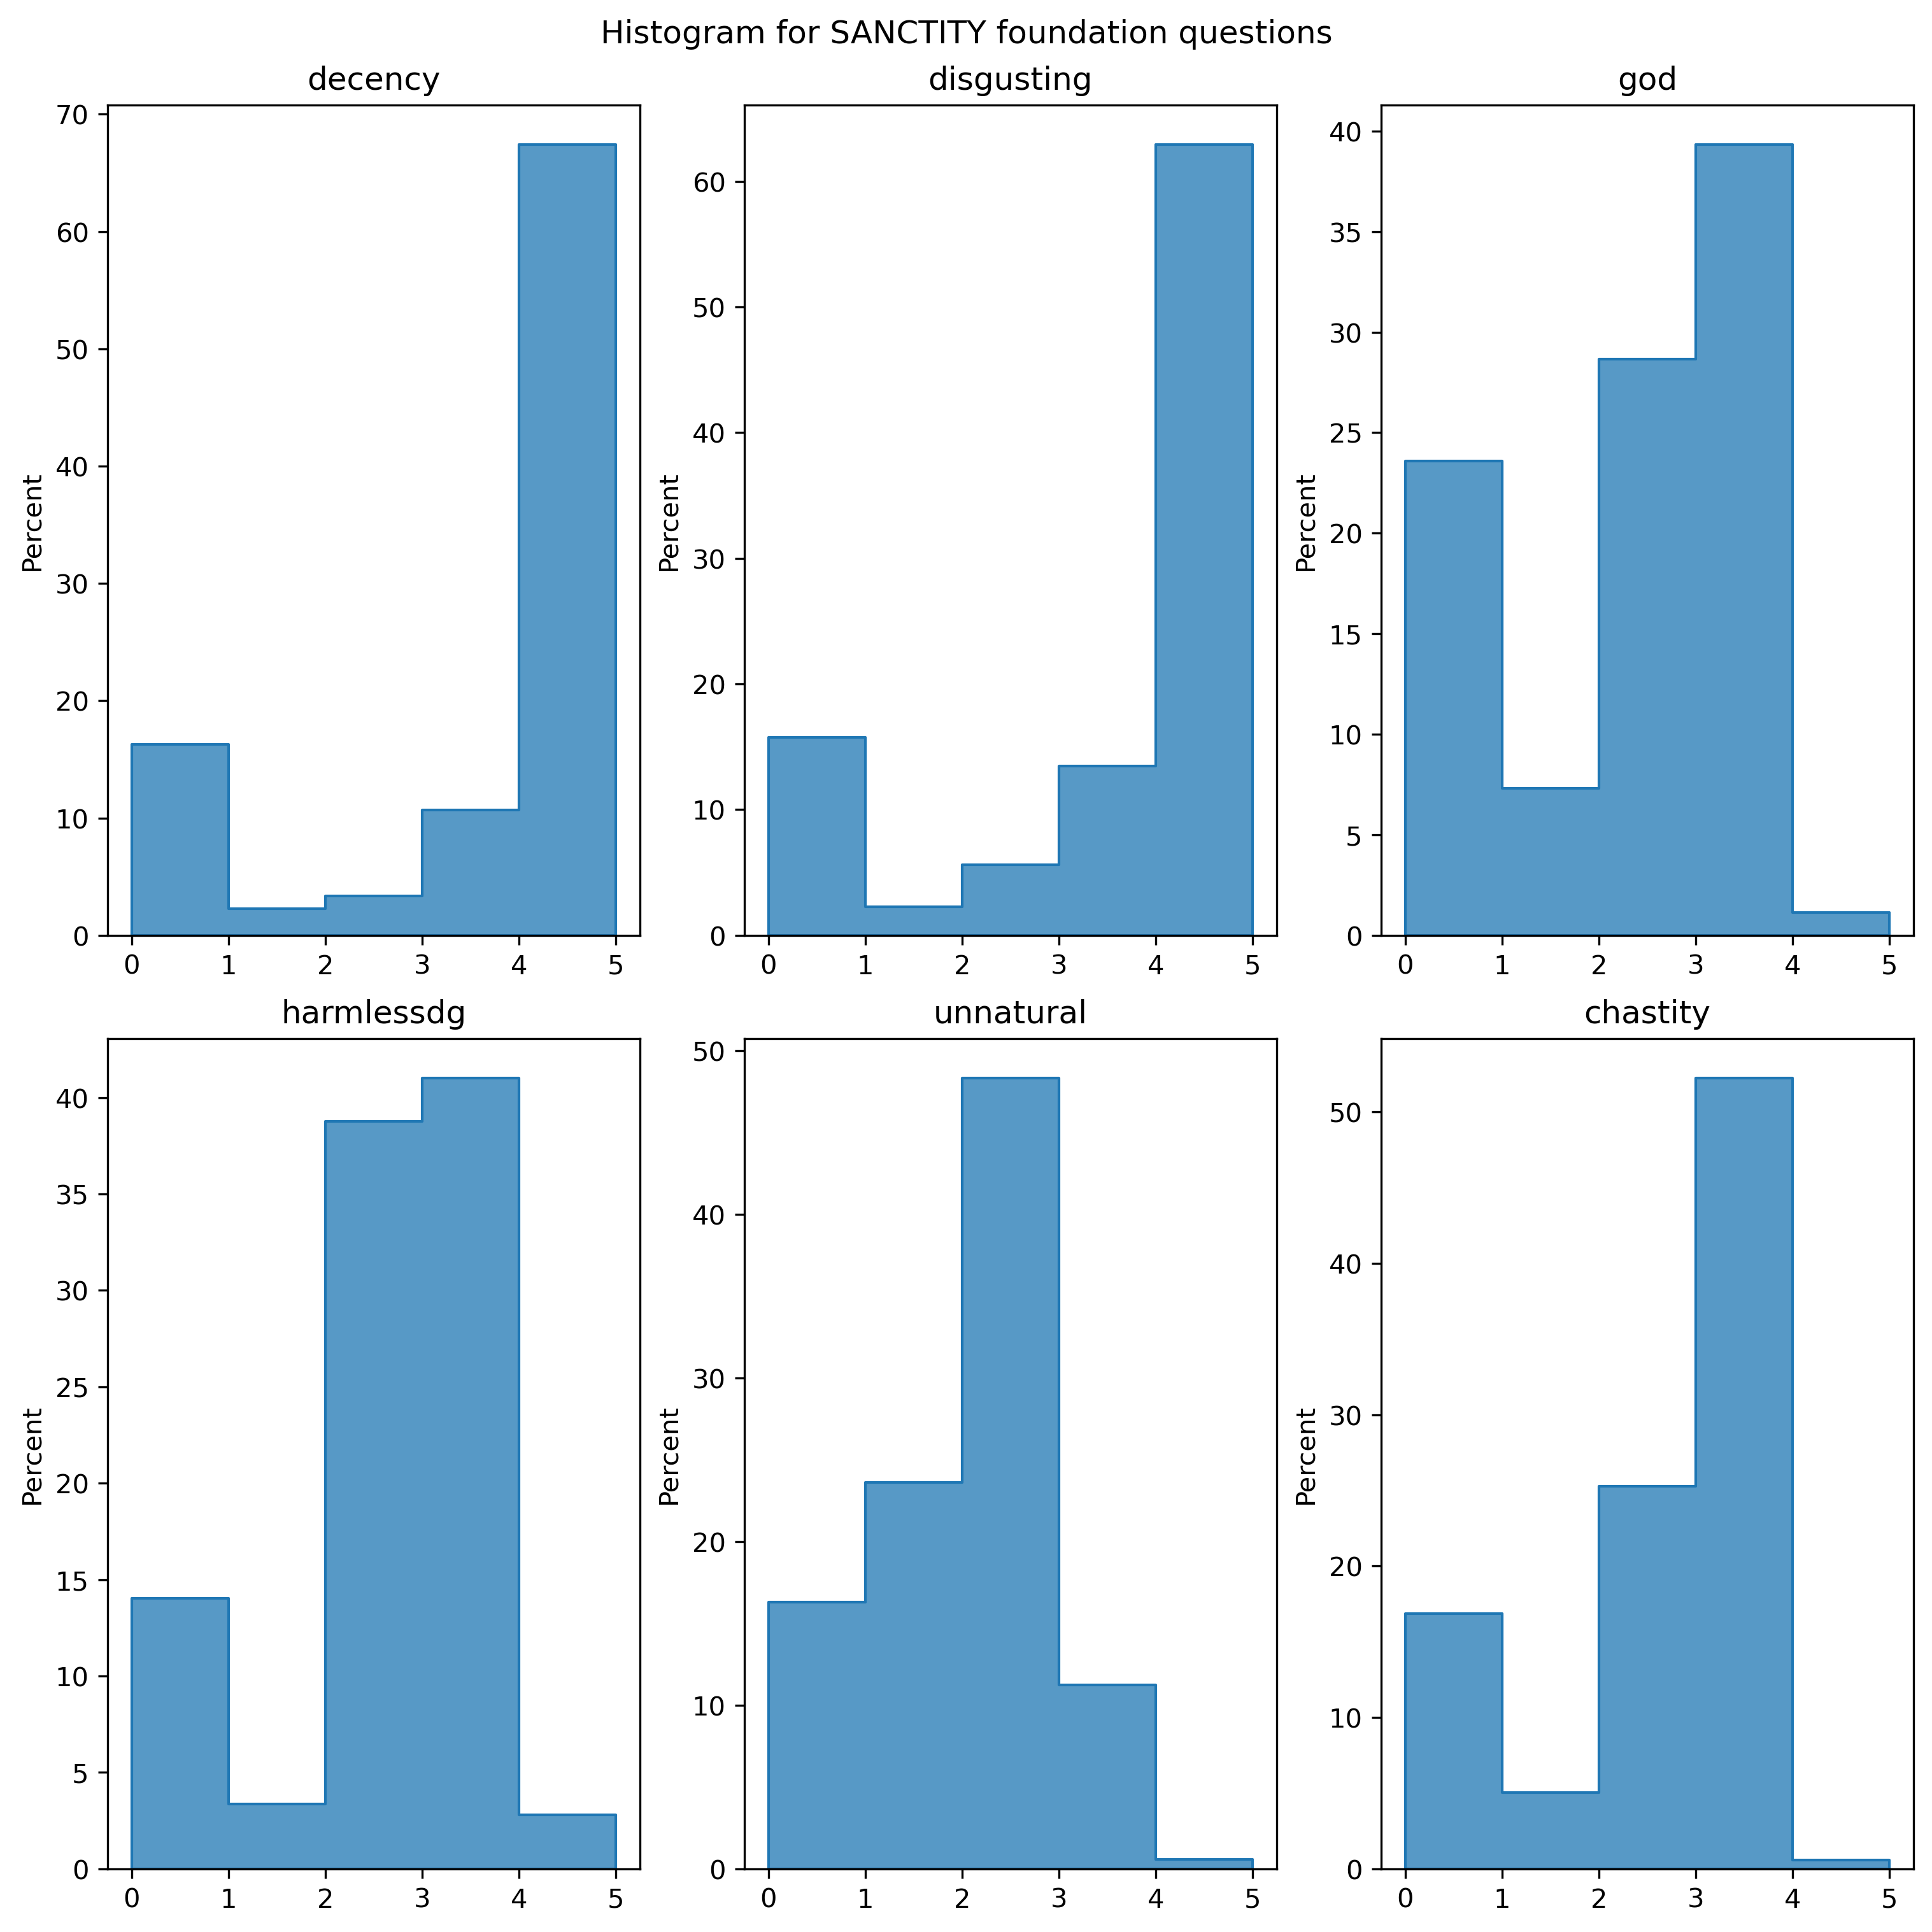

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
# create a histogram for each question in each foundation
for foundation, questions in questions_dict.items():
    fig, axs = plt.subplots(figsize=(10, 10), constrained_layout=True, dpi=300, nrows=2, ncols=3)
    plt.suptitle(f"Histogram for {foundation.upper()} foundation questions")
    for i, question in enumerate(questions):
        ax = axs[i // 3, i % 3]
        sns.histplot(
            data=df_chat,
            x=question,
            color="tab:blue",
            bins=[0,1,2,3,4,5],
            # palette="colorblind",
            # hue="condition",
            # multiple="layer",
            element="step",
            stat="percent",
            ax=ax,
            legend=False,
        )
        ax.set_xlabel("")
        ax.set_title(question)


# Calculate cronbach per foundation in MFV

Loading data to obtain foundation per vignette

In [67]:
from helpers import original_validated
x = original_validated.copy()

In [68]:
# replace 'Care (p,a)' with 'Care (p)' and 'Care (p,h)' with 'Care (p)'
original_validated["Foundation"] = original_validated["Foundation"].replace(
    {
        "Care (p,a)": "Care (p)",
        "Care (p,h)": "Care (p)",
    },
)

Calculate cronbach per foundation in MFVs

In [69]:
print("Calculation internal consistency for MFV")
for f in original_validated["Foundation"].unique():
    codes = original_validated.query("Foundation == @f")["mfv_code"].astype(str).unique().tolist()
    print(f"Cronbach for {f.upper()}:", cronbach_alpha(df_chat[codes]))
    alphas.append(
        ["MFV", f.title(), "overall", cronbach_alpha(df_chat[codes])[0]]
    )
    # cronbach before
    print(
        "Before condition:",
        cronbach_alpha(df_chat.query("condition == 'before'")[codes])
    )
    alphas.append(
        ["MFV", f.title(), "before", cronbach_alpha(df_chat.query("condition == 'before'")[codes])[0]]
    )
    # after
    print(
        "After condition:",
        cronbach_alpha(df_chat.query("condition == 'after'")[codes])
    )
    alphas.append(
        ["MFV", f.title(), "after", cronbach_alpha(df_chat.query("condition == 'after'")[codes])[0]]
    )
    # also add mean to df_chat
    df[f"MFV_{f.title()}"] = df_chat[codes].mean(axis=1)
    

Calculation internal consistency for MFV
Cronbach for CARE (E): (0.8836660262328352, array([0.857, 0.907]))
Before condition: (0.854150010830396, array([0.814, 0.889]))
After condition: (0.8284368949128674, array([0.748, 0.891]))
Cronbach for CARE (P): (0.4218042464696612, array([0.285, 0.541]))
Before condition: (0.3621045392022008, array([0.182, 0.516]))
After condition: (0.2773972602739726, array([-0.066,  0.543]))
Cronbach for FAIRNESS: (0.809813812643351, array([0.765, 0.849]))
Before condition: (0.7883332738880764, array([0.729, 0.839]))
After condition: (0.8041420118343194, array([0.711, 0.876]))
Cronbach for LIBERTY: (0.9043343582475112, array([0.881, 0.924]))
Before condition: (0.8567212040556565, array([0.815, 0.892]))
After condition: (0.9251946079362067, array([0.889, 0.953]))
Cronbach for AUTHORITY: (0.8818911539746898, array([0.854, 0.906]))
Before condition: (0.8756581119355007, array([0.841, 0.905]))
After condition: (0.8481555987437537, array([0.777, 0.904]))
Cronbach 

In [70]:
alphas_df = pd.DataFrame(alphas, columns=["scale", "foundation", "condition", "alpha"])
alphas_df["model"] = model
alphas_df.to_csv(f"data/{model}_cronbach.csv", index=False, encoding="utf-8-sig")

# Regressing MFV mean per foundation on MFQ foundation mean

In [71]:
df.columns

Index(['id', 'condition', 'MFQ_care', 'MFQ_fairness', 'MFQ_loyalty',
       'MFQ_authority', 'MFQ_sanctity', 'MFV_Care (E)', 'MFV_Care (P)',
       'MFV_Fairness', 'MFV_Liberty', 'MFV_Authority', 'MFV_Loyalty',
       'MFV_Sanctity'],
      dtype='object')

Standardizing variables

In [72]:
# standardize the scores
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.columns[2:]] = scaler.fit_transform(df[df.columns[2:]])

In [73]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

In [74]:
formula = "Q('{}') ~ MFQ_care + MFQ_fairness + MFQ_loyalty + MFQ_authority + MFQ_sanctity"

dependents = [x for x in df.columns if x.startswith("MFV_")]

Running models

In [75]:
models = list()

for i in dependents:
    mod = smf.ols(formula=formula.format(i), data=df)
    res = mod.fit()
    models.append(res)

output = summary_col(models, stars=True)
print(output)


               Q('MFV_Care (E)') Q('MFV_Care (P)') Q('MFV_Fairness') Q('MFV_Liberty') Q('MFV_Authority') Q('MFV_Loyalty') Q('MFV_Sanctity')
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept      -0.0000           -0.0000           0.0000            -0.0000          0.0000             0.0000           -0.0000          
               (0.0698)          (0.0699)          (0.0712)          (0.0709)         (0.0730)           (0.0747)         (0.0745)         
MFQ_care       0.0243            -0.0428           -0.2196           -0.3510          0.1690             0.5173*          0.1335           
               (0.2657)          (0.2662)          (0.2709)          (0.2697)         (0.2776)           (0.2843)         (0.2836)         
MFQ_fairness   0.0794            0.1132            0.1897            0.4882*          -0.1273            -0.4050          -0.3080          
               (0.2

# Regressing on Factors

In [76]:
from helper_factor_analysis import run_factor_analysis

In [77]:
codes_vignettes = original_validated["mfv_code"].astype(str).unique()

Saving factor loading to investigate its coherence.

Saving was commented to run some visual highlighting on excel file.

ML method takes a couple dozen seconds to run

In [78]:
factor_df, factor_model = run_factor_analysis(df_chat[codes_vignettes], n_factors=7, method="ml", return_model=True, vignettes="original")

factor_df.to_excel(f"data/final/factor_analysis_{model}.xlsx")

Columns with no variation: ['201', '207', '208', '801', '802', '803', '804'].
Dropping.....
KMO: 0.8462869592090361


/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Cumulative variance explained by 7 factors: 0.4728711118597136
Variance: [0.10533753 0.08501062 0.07974692 0.06265437 0.05759504 0.05113578
 0.03139086]


In [79]:
factor_cols = [f"Factor_{i}" for i in range(1, 8)]
df_with_factors = pd.concat(
    [
        df.reset_index(drop=True),
        pd.DataFrame(
            factor_model.transform(df_chat[factor_df["MFV Code"].astype(str).values]),
            columns=factor_cols,
        ),
    ],
    axis=1,
)

df_with_factors.head(2)


,id,condition,MFQ_care,MFQ_fairness,MFQ_loyalty,MFQ_authority,MFQ_sanctity,MFV_Care (E),MFV_Care (P),MFV_Fairness,...,MFV_Authority,MFV_Loyalty,MFV_Sanctity,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
0,1,before,0.365657,-0.096368,0.795524,0.566954,0.755280,-0.400873,-0.886112,-2.452225,...,-0.468277,0.104424,0.418271,-0.272275,0.023922,-0.916243,-0.425949,0.142902,-2.063651,-0.087655
1,2,before,-0.179004,-0.096368,0.362927,0.566954,0.303128,0.882497,1.175691,1.128873,...,-0.726336,-0.274911,1.185819,0.821739,-0.334350,-0.190718,0.144842,0.231873,0.520816,0.194071


In [80]:
models = list()

for i in factor_cols:
    mod = smf.ols(formula=formula.format(i), data=df_with_factors)
    res = mod.fit()
    models.append(res)

output_factors = summary_col(models, stars=True)

print(output_factors)


               Q('Factor_1') Q('Factor_2') Q('Factor_3') Q('Factor_4') Q('Factor_5') Q('Factor_6') Q('Factor_7')
----------------------------------------------------------------------------------------------------------------
Intercept      0.0000        -0.0000       0.0000        -0.0000       0.0000        0.0000        -0.0000      
               (0.0670)      (0.0717)      (0.0684)      (0.0690)      (0.0696)      (0.0675)      (0.0754)     
MFQ_care       0.0982        0.4290        -0.0485       -0.4760*      0.6924***     -0.2335       0.0198       
               (0.2548)      (0.2728)      (0.2602)      (0.2626)      (0.2648)      (0.2571)      (0.2868)     
MFQ_fairness   0.0068        -0.3552       0.0818        0.5580**      -0.4912*      0.1995        -0.0866      
               (0.2551)      (0.2731)      (0.2605)      (0.2629)      (0.2652)      (0.2574)      (0.2871)     
MFQ_loyalty    -0.2908       -0.0045       -0.7639***    -0.1121       0.2346        -0.3821   

In [81]:
print(output_factors.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllllll}
\hline
               & Q('Factor\_1') & Q('Factor\_2') & Q('Factor\_3') & Q('Factor\_4') & Q('Factor\_5') & Q('Factor\_6') & Q('Factor\_7')  \\
\hline
Intercept      & 0.0000         & -0.0000        & 0.0000         & -0.0000        & 0.0000         & 0.0000         & -0.0000         \\
               & (0.0670)       & (0.0717)       & (0.0684)       & (0.0690)       & (0.0696)       & (0.0675)       & (0.0754)        \\
MFQ\_care      & 0.0982         & 0.4290         & -0.0485        & -0.4760*       & 0.6924***      & -0.2335        & 0.0198          \\
               & (0.2548)       & (0.2728)       & (0.2602)       & (0.2626)       & (0.2648)       & (0.2571)       & (0.2868)        \\
MFQ\_fairness  & 0.0068         & -0.3552        & 0.0818         & 0.5580**       & -0.4912*       & 0.1995         & -0.0866         \\
               & (0.2551)       & (0.2731)       & (0.2605)       & (0.2629)       

# Before condition models

In [82]:
# use MFV columns as regressors
formula = "Q('{}') ~ Q('MFV_Care (E)') + Q('MFV_Care (P)') + MFV_Fairness + MFV_Loyalty + MFV_Authority + MFV_Sanctity"

dependents = [x for x in df.columns if x.startswith("MFQ_")]

Running models

In [83]:
models = list()

for i in dependents:
    mod = smf.ols(formula=formula.format(i), data=df.query("condition == 'before'"))
    res = mod.fit()
    models.append(res)

output = summary_col(models, stars=True)

print(output)


                  Q('MFQ_care') Q('MFQ_fairness') Q('MFQ_loyalty') Q('MFQ_authority') Q('MFQ_sanctity')
-------------------------------------------------------------------------------------------------------
Intercept         0.1199***     0.1368***         0.4727***        0.4611***          0.4860***        
                  (0.0197)      (0.0139)          (0.0282)         (0.0271)           (0.0325)         
Q('MFV_Care (E)') -0.0397       -0.0158           -0.0529          -0.0667*           -0.0412          
                  (0.0286)      (0.0203)          (0.0410)         (0.0393)           (0.0473)         
Q('MFV_Care (P)') 0.0342        -0.0140           -0.0033          0.0204             0.0517           
                  (0.0280)      (0.0198)          (0.0401)         (0.0384)           (0.0461)         
MFV_Fairness      -0.0260       0.0176            0.0341           0.0764*            -0.0041          
                  (0.0283)      (0.0200)          (0.0405)     

In [84]:
factor_models = list()

# now regressing from factors
formula_factors = "Q('{}') ~ Factor_1 + Factor_2 + Factor_3 + Factor_4 + Factor_5 + Factor_6 + Factor_7"

for i in dependents:
    mod = smf.ols(formula=formula_factors.format(i), data=df_with_factors.query("condition == 'before'"))
    res = mod.fit()
    factor_models.append(res)

before_factors = summary_col(factor_models, stars=True)

print(before_factors)


               Q('MFQ_care') Q('MFQ_fairness') Q('MFQ_loyalty') Q('MFQ_authority') Q('MFQ_sanctity')
----------------------------------------------------------------------------------------------------
Intercept      0.1290***     0.1313***         0.4680***        0.4589***          0.5118***        
               (0.0214)      (0.0147)          (0.0300)         (0.0292)           (0.0346)         
Factor_1       -0.0182       -0.0375           -0.0632          -0.0438            -0.0167          
               (0.0339)      (0.0233)          (0.0476)         (0.0464)           (0.0548)         
Factor_2       0.0192        -0.0115           0.0903**         0.0376             0.0307           
               (0.0272)      (0.0187)          (0.0382)         (0.0372)           (0.0440)         
Factor_3       0.0438        0.0358*           -0.0122          0.0336             0.0691           
               (0.0305)      (0.0210)          (0.0430)         (0.0418)           (0.0494

In [85]:
print(before_factors.as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llllll}
\hline
               & Q('MFQ\_care') & Q('MFQ\_fairness') & Q('MFQ\_loyalty') & Q('MFQ\_authority') & Q('MFQ\_sanctity')  \\
\hline
Intercept      & 0.1290***      & 0.1313***          & 0.4680***         & 0.4589***           & 0.5118***           \\
               & (0.0214)       & (0.0147)           & (0.0300)          & (0.0292)            & (0.0346)            \\
Factor\_1      & -0.0182        & -0.0375            & -0.0632           & -0.0438             & -0.0167             \\
               & (0.0339)       & (0.0233)           & (0.0476)          & (0.0464)            & (0.0548)            \\
Factor\_2      & 0.0192         & -0.0115            & 0.0903**          & 0.0376              & 0.0307              \\
               & (0.0272)       & (0.0187)           & (0.0382)          & (0.0372)            & (0.0440)            \\
Factor\_3      & 0.0438         & 0.0358*            & -0.0122           